In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/banglaalphabet-ekushedataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications import ResNet50,VGG16 ,VGG19,EfficientNetB0,DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Input

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib  # For saving the model

import cv2
import os
import io

2024-03-31 11:51:19.587739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 11:51:19.587876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 11:51:19.715453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['1', '2', '3', '4','5', '6', '7', '8', '9', '10','11' ]

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 64


for label in labels:
    trainPath = os.path.join('/kaggle/input/banglaalphabet-ekushedataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/kaggle/input/banglaalphabet-ekushedataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

100%|██████████| 60/60 [00:00<00:00, 365.22it/s]


In [4]:
x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0
#print(x_train[0])
print(x_train.shape)
print(x_test.shape)

(16573, 64, 64, 3)
(660, 64, 64, 3)


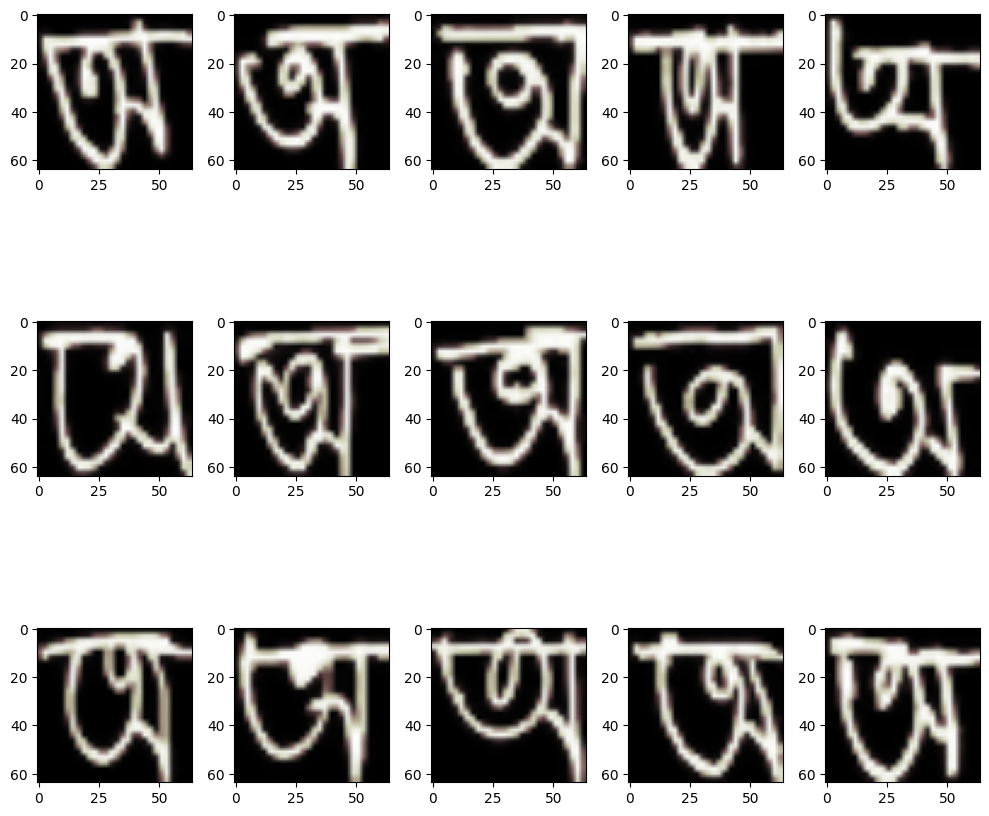

In [5]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
# output_figure_path = '/kaggle/output/'
# fig.savefig(output_figure_path)

plt.show()

In [6]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_train.shape)

(13258, 64, 64, 3)


In [7]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)
print(x_train.shape)

(13258, 64, 64, 3)


In [8]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(11, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,610,251 (90.07 MB)

 Trainable params: 23,557,131 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

#callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),validation_data = (x_val,y_val),epochs = EPOCHS)
model_path = '/kaggle/working/bangla_alphabet.joblib'
# joblib.dump(model, model_path)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/208 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0781 - loss: 3.5124   

I0000 00:00:1711886012.379312      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711886012.472625      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/208 ━━━━━━━━━━━━━━━━━━━━ 122s 278ms/step - accuracy: 0.5235 - loss: 1.6089 - val_accuracy: 0.0920 - val_loss: 9.5893
Epoch 2/50


W0000 00:00:1711886069.957336      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9177 - loss: 0.2700 - val_accuracy: 0.1161 - val_loss: 5.5979
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.9553 - loss: 0.1400 - val_accuracy: 0.2133 - val_loss: 2.1455
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9664 - loss: 0.1086 - val_accuracy: 0.7873 - val_loss: 0.6603
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9775 - loss: 0.0717 - val_accuracy: 0.9173 - val_loss: 0.2393
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.9773 - loss: 0.0708 - val_accuracy: 0.9716 - val_loss: 0.0975
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9808 - loss: 0.0619 - val_accuracy: 0.9777 - val_loss: 0.0899
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9825 - loss: 0.0560 - val_accuracy: 0.9762 - val_loss: 0.1018
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9896 - loss: 0.0385 - val

In [11]:
import cv2
import numpy as np

# Load the image
image_path = '/kaggle/input/banglaalphabet-ekushedataset/Testing/3/1_B.BARIA_11_1_319.jpg'  # Provide the path to your image
input_image = cv2.imread(image_path)
input_image = cv2.resize(input_image, (image_size, image_size))  # Resize to match the model's input size
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Preprocess the input image (normalize pixel values)
input_image = input_image / 255.0

# Predict the class of the input image
predictions = model.predict(input_image)

# Get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class = labels[predicted_class_index]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


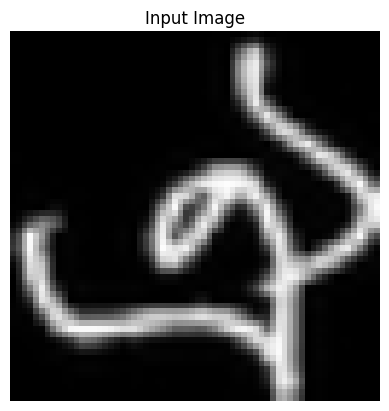

Predicted class: 9


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/input/banglaalphabet-ekushedataset/Testing/9/1_B.BARIA_12_1_325.jpg'  # Provide the path to your image
input_image = cv2.imread(image_path)
input_image = cv2.resize(input_image, (image_size, image_size))  # Resize to match the model's input size
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Preprocess the input image (normalize pixel values)
input_image = input_image / 255.0

# Predict the class of the input image
predictions = model.predict(input_image)

# Get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class = labels[predicted_class_index]

# Display the input image
input_image_display = (input_image * 255).astype(np.uint8)  # Convert to uint8 for display
plt.imshow(cv2.cvtColor(input_image_display.squeeze(), cv2.COLOR_BGR2RGB))
plt.title('Input Image')
plt.axis('off')
plt.show()

print("Predicted class:", predicted_class)

In [13]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step


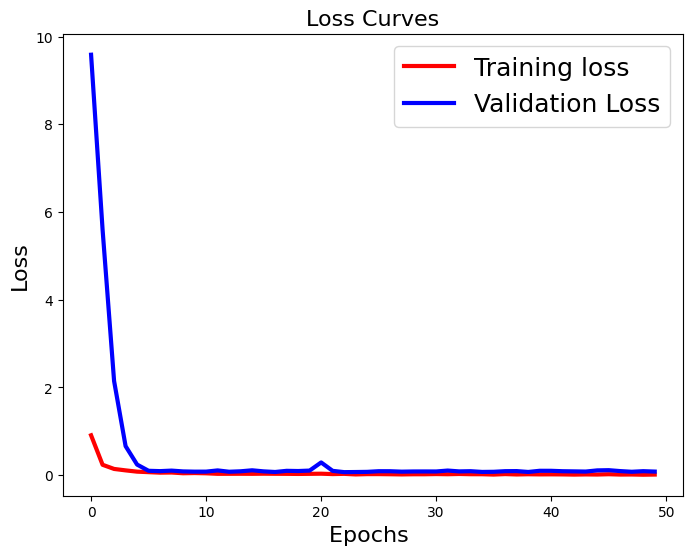

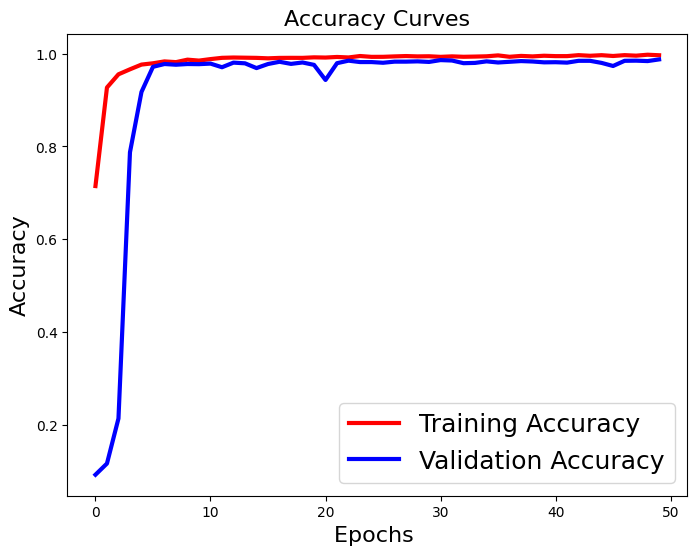

In [14]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.savefig('/kaggle/working/lossdense121.png',dpi=300)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.savefig('/kaggle/working/accuracy_dense121.png',dpi=300)
plt.show()

In [15]:
# Generate predictions on the validation set
y_pred = model.predict(x_val)

104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


W0000 00:00:1711887221.664368      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_pred contains predicted probabilities for each class
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

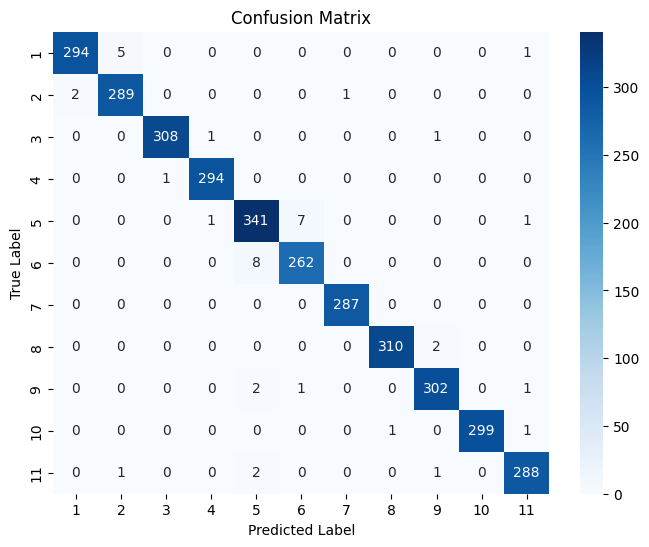

In [17]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
# confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
# plt.figure(figsize = (16, 16))
# sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True, fmt='d')  # fmt='d' for integer format

#sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.97      1.00      0.98        60
           2       0.97      0.97      0.97        60
           3       0.97      0.98      0.98        60
           4       0.97      0.97      0.97        60
           5       0.97      0.95      0.96        60
           6       0.98      1.00      0.99        60
           7       1.00      0.98      0.99        60
           8       0.98      0.98      0.98        60
           9       1.00      1.00      1.00        60
          10       1.00      1.00      1.00        60

    accuracy                           0.98       660
   macro avg       0.98      0.98      0.98       660
weighted avg       0.98      0.98      0.98       660



104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


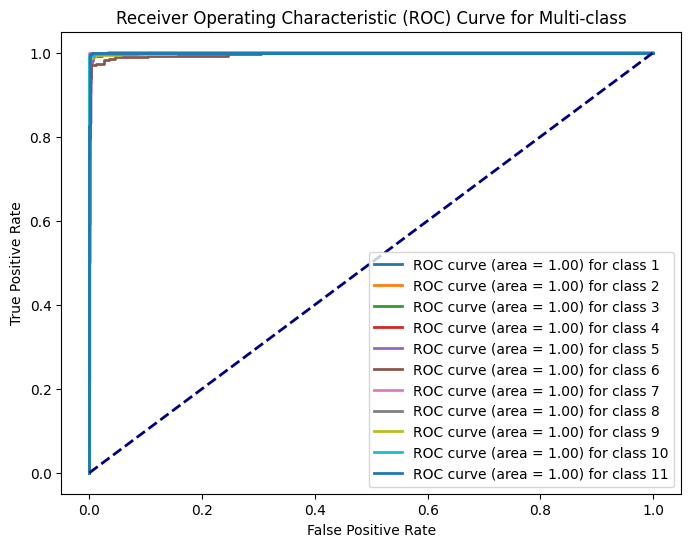

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Generate predictions on the validation set
y_pred = model.predict(x_val)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_val, axis=1)

# Generate ROC-AUC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve((y_true_classes == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], labels[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
loss,acc = model.evaluate(x_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9776 - loss: 0.1440
